In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi,sqrt,e,shape,zeros,fft
import scipy.special as sc
import scipy
import matplotlib.animation as anim

In [12]:
from __future__ import division

## For creating GIFS in jupyter
class AnimatedGif:
    def __init__(self, size=(300, 300)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 20, size[1] / 20)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label=''):
        plt_im = plt.imshow(image,animated=True,cmap = 'hsv')
        plt_txt = plt.text(10, 310, label, color='red')
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=10)

##easy 3-d plots calling
def three_d(X,Y,z,title): #Takes meshgrid and 'title'
    fig = plt.figure(figsize = (12,12))
    ax = plt.axes(projection='3d')

    surf = ax.plot_surface(X, Y, z, cmap = plt.cm.cividis)
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=10)
    plt.title(title)
    fig.colorbar(surf, shrink=0.3, aspect=20)
#     ax.view_init(90, 45)
    ax.view_init(10, 20)
    plt.show()

##easy interactive 3-d plot
def interact_threed(X,Y,Z):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    import numpy as np
    %matplotlib qt
    
    fig = plt.figure(dpi=200)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap = 'plasma',
                   linewidth=1, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    for angle in range(0, 360):
           ax.view_init(30, 40)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [13]:
##fft 1D 
def my_fft(f,L,N,dx):
    fft = np.zeros(N,dtype = 'complex')
    shift = N/2
    for k in range(N):
        for n in range(N):
            fft[k] += dx*f[n]*np.e**(-(1j*2*np.pi/N)*(k-shift)*(n-shift))
    return fft

##ifft 1D
def my_ifft(F,L,N,dx):
    ifft = np.zeros(N,dtype = 'complex')
    shift = N/2
    for n in range(N):
        for k in range(N):
            ifft[n] += (1/L)*F[k]*np.e**((1j*2*np.pi/N)*(k-shift)*(n-shift))
    return ifft

##fft 2D
def my_fft_2d(f,L,N,dx):
    m,n = np.shape(f)
    fft2 = np.zeros((m,n),dtype = 'complex_')
    for i in range(m):
        fft2[i] = my_fft(f[i],L,N,dx)
    for j in range(n):
        fft2[:,j] = my_fft(fft2[:,j],L,N,dx)
    return fft2

##ifft 2D
def my_ifft_2d(F,L,N,dx):
    m,n = np.shape(F)
    ifft2 = np.zeros((m,n),dtype = 'complex_')
    for i in range(m):
        ifft2[i] = my_ifft(F[i],L,N,dx)
    for j in range(n):
        ifft2[:,j] = my_ifft(ifft2[:,j],L,N,dx)
    return ifft2 

##derivative in fourier space
def my_ifft_2d_deriv(F,L,N,dx,F_x,F_y):
    m,n = np.shape(F)
    ifft2 = np.zeros((m,n),dtype = 'complex_')
    freq_x = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_y = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    for i in range(m):
        ifft2[i] = my_ifft((1j*freq_x)**F_x*F[i],L,N,dx)
    for j in range(n):
        ifft2[:,j] = my_ifft((1j*freq_y)**F_y*ifft2[:,j],L,N,dx)      
    return ifft2 

In [14]:
##Fresnel weights as outlined in write-up
def fresnel_weights(L,N,x,y,z,k):
    X, Y = np.meshgrid(x, y)
    dx = L/N
    fres_x = zeros(shape(X),dtype = 'complex')
    fres_y = zeros(shape(X),dtype = 'complex')
    W = 1/(2*dx)
    delta = dx

    for m in range(len(x)):
        for j in range(len(x)):
            slide = x[m] - x[j]
            u_1x = -pi*sqrt(2*z/k)*W - sqrt(k/(2*z))*slide
            u_2x = pi*sqrt(2*z/k)*W - sqrt(k/(2*z))*slide
            S_1x,C_1x = sc.fresnel(u_1x*sqrt(2/pi))
            S_2x,C_2x = sc.fresnel(u_2x*sqrt(2/pi))
            phi_x = (delta/pi)*sqrt(k/(2*z))*e**(1j*slide**2*k/(2*z))*sqrt(pi/2)*(C_2x - C_1x - 1j*(S_2x - S_1x))
            fres_x[m,j] = phi_x

    return fres_x,fres_x

In [15]:
##Circular aperature initial condition with sinc based method
def circular_aperature_sinc(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    
    r_0 = 1e-3
    x_0 = 0
    y_0 = 0
    z_0 = -3e-2
    A = 3e-2

    lam = 1e-5
    k = np.pi*2/lam
    z1 = 0

    circ = np.sqrt(X**2 + Y**2)/r_0

    for i in range(len(x)):
        for j in range(len(y)): 
            if circ[i,j] > 1:
                circ[i,j] = 0
            else: 
                circ[i,j] = 1
            
    f = A*circ*(np.e**(1j*k*np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)))/np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)  

#     z = .015
    w_x,w_y = fresnel_weights(L,N,x,y,z,k)
    return e**(1j*k*z)*w_x@f@w_y.T

In [16]:
##circular aperature initial condition with fft
def circular_aperature_ft_builtin(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    freq_x = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_y = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    X, Y = np.meshgrid(x, y)
    freq_x,freq_y = np.meshgrid(freq_x,freq_y)
    
    r_0 = 1e-3
    x_0 = 0
    y_0 = 0
    z_0 = -3e-2
    A = 3e-2

    lam = 1e-5
    k = np.pi*2/lam
    z1 = 0

    circ = np.sqrt(X**2 + Y**2)/r_0

    for i in range(len(x)):
        for j in range(len(y)): 
            if circ[i,j] > 1:
                circ[i,j] = 0
            else: 
                circ[i,j] = 1
            
    f = A*circ*(np.e**(1j*k*np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)))/np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2) 
    
#     z = .015

    fft2 = fft.fftshift(fft.fft2(f))
    
    fft2_prop = np.e**(1j*k*z)*fft2*np.e**(((freq_y)**2 + (freq_x)**2)*z/(2*1j*k))
    
    return fft.ifft2(fft2_prop)

In [17]:
##circular aperature initial condition with my_fft
def circular_aperature_ft(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    freq_x = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_y = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    X, Y = np.meshgrid(x, y)
    freq_x,freq_y = np.meshgrid(freq_x,freq_y)
    
    r_0 = 1e-3
    x_0 = 0
    y_0 = 0
    z_0 = -3e-2
    A = 3e-2

    lam = 1e-5
    k = np.pi*2/lam
    z1 = 0

    circ = np.sqrt(X**2 + Y**2)/r_0

    for i in range(len(x)):
        for j in range(len(y)): 
            if circ[i,j] > 1:
                circ[i,j] = 0
            else: 
                circ[i,j] = 1
            
    f = A*circ*(np.e**(1j*k*np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2)))/np.sqrt((X-x_0)**2 + (Y-y_0)**2 + (z1-z_0)**2) 
    
#     z = .015
    
    fft2 = my_fft_2d(f,L,N,dx)
    fft2_prop = np.e**(1j*k*z)*fft2*np.e**(((freq_y)**2 + (freq_x)**2)*z/(2*1j*k))
    
    return my_ifft_2d(fft2_prop,L,N,dx)

In [18]:
##Gaussian Initial condition with sinc method
def gaussian_sinc(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    
    w = 1e-2
    f = np.e**(-(X**2 + Y**2)/(w**2))

    lam = 1e-6
    k = np.pi*2/lam
#     z = 100    
  
    w_x,w_y = fresnel_weights(L,N,x,y,z,k)
    return e**(1j*k*z)*w_x@f@w_y.T

In [19]:
##Gaussian Initial Condition with FFT
def gaussian_ft_builtin(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    freq_x = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_y = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    X, Y = np.meshgrid(x, y)
    freq_x,freq_y = np.meshgrid(freq_x,freq_y)
    
    w = 1e-2
    f = np.e**(-(X**2 + Y**2)/(w**2))

    lam = 1e-6
    k = np.pi*2/lam
#     z = 100
    
    fft2 = fft.fftshift(fft.fft2(f))
    
    fft2_prop = np.e**(1j*k*z)*fft2*np.e**(((freq_y)**2 + (freq_x)**2)*z/(2*1j*k))
    
    return fft.ifft2(fft2_prop)

In [20]:
##Gaussian with analytic solution 
def gaussian_analytic(L,N,z):
    dx = L/N
    x = np.linspace(-L/2,L/2-dx,N)
    y = np.linspace(-L/2,L/2-dx,N)
    X, Y = np.meshgrid(x, y)
    
    w = 1e-2
    lam = 1e-6
    k = np.pi*2/lam
#     z = 100
    
    fd = (1/np.sqrt(1+(2*z/(k*w**2))**2))*np.e**((-1/(w**2))*(X**2+Y**2)/(1+(2*z/(k*w**2))**2)+ 1j*k*z-1j*np.arctan(2*z/(k*w**2)) + (1j*k/(2*z))*((X**2+Y**2)/(1+(k*w**2/(2*z))**2)))
    
    return fd

In [21]:
##Time comparison of the two methods

def gaussian_sinc_timetest(f,L,N,x,y,z,k):
    w_x,w_y = fresnel_weights(L,N,x,y,z,k)
    return e**(1j*k*z)*w_x@f@w_y.T

def gaussian_fft_timetest(f,L,N,x,y,z,k):
    freq_x = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_y = np.linspace(-N/2,N/2-1,N)*(2*np.pi)/L
    freq_x,freq_y = np.meshgrid(freq_x,freq_y)
    fft2 = fft.fftshift(fft.fft2(f))
    fft2_prop = np.e**(1j*k*z)*fft2*np.e**(((freq_y)**2 + (freq_x)**2)*z/(2*1j*k)) 
    return fft.ifft2(fft2_prop)

In [22]:
N = 2**6
L = 2
dx = L/N
x = np.linspace(-L/2,L/2-dx,N)
y = np.linspace(-L/2,L/2-dx,N)
X, Y = np.meshgrid(x, y)
w = 1e-2
f = np.e**(-(X**2 + Y**2)/(w**2))
lam = 1e-6
k = np.pi*2/lam
z=100

In [23]:
%%timeit
gaussian_fft_timetest(f,L,N,x,y,z,k)

518 µs ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%%timeit
gaussian_sinc_timetest(f,L,N,x,y,z,k)

64.3 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


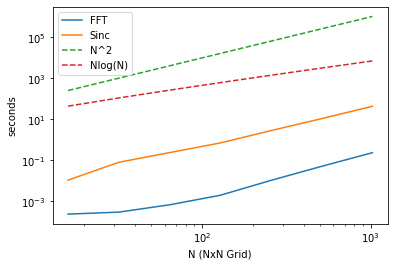

In [25]:
#times are in mean ms
N = np.array([2**4,2**5,2**6,2**7,2**8,2**9,2**10])
fft_times = np.array([.24,.3,.682,1.99,10.6,51.4,238])
sinc_times = np.array([10.9,80.7,240,709,2840,10900,43700])
plt.loglog(N,fft_times/1000,label = 'FFT')
plt.loglog(N,sinc_times/1000,label = 'Sinc')
plt.loglog(N,N*N,linestyle = 'dashed',label = 'N^2')
plt.loglog(N,N*np.log(N),linestyle = 'dashed',label = 'Nlog(N)')
plt.xlabel("N (NxN Grid)")
plt.ylabel("seconds")
# plt.yscale('log')
plt.legend()
plt.show()

Computing error with fixed dx

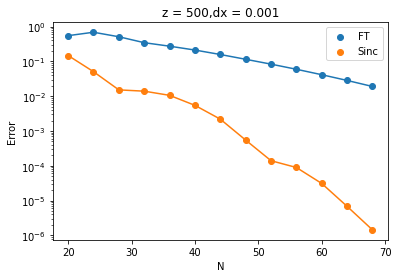

In [26]:
error_sinc = []
grid_sinc = []
error_four = []
grid_four = []
for N in range(20,70,4):
    dx = 1e-3
    L = N*dx
    z = 500

    fd = gaussian_analytic(L,N,z)
    U = gaussian_sinc(L,N,z)
    
    error_sinc.append(np.linalg.norm(abs(fd) - abs(U))/np.linalg.norm(abs(fd)))
    grid_sinc.append(N)

    FT = gaussian_ft_builtin(L,N,z)
                      
    error_four.append(np.linalg.norm(abs(fd) - abs(FT))/np.linalg.norm(abs(fd)))
    grid_four.append(N)
    
plt.plot(grid_four,error_four)
plt.scatter(grid_four,error_four,label = 'FT')
plt.plot(grid_sinc,error_sinc)
plt.scatter(grid_sinc,error_sinc,label = 'Sinc')
plt.title('z = ' + str(z) + ',dx = ' + str(dx))
plt.ylabel('Error')
plt.xlabel('N')
plt.yscale('log')
plt.legend()
plt.show()

Computing error with fixed L

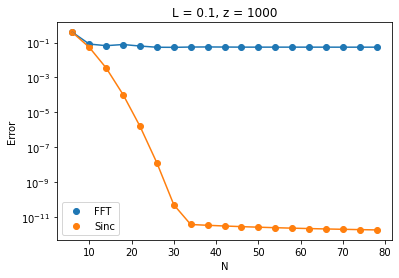

In [27]:
error_sinc = []
error_fft = []
grid_N = []

for N in range(6,80,4):
    L = 1e-1
    dx = L/N
    z = 1000
    
    sinc_sol = gaussian_sinc(L,N,z)
    
    analytic_sol = gaussian_analytic(L,N,z)
    
    error_sinc.append(np.linalg.norm(abs(sinc_sol) - abs(analytic_sol))/np.linalg.norm(abs(analytic_sol)))
    
    fft_sol = gaussian_ft_builtin(L,N,z)

    error_fft.append(np.linalg.norm(abs(fft_sol) - abs(analytic_sol))/np.linalg.norm(abs(analytic_sol)))
    
    grid_N.append(N)
    
plt.plot(grid_N,error_fft)
plt.scatter(grid_N,error_fft,label = 'FFT')
plt.plot(grid_N,error_sinc)
plt.scatter(grid_N,error_sinc,label = 'Sinc')
plt.title('L = ' + str(L) + ', z = ' + str(z))
plt.ylabel('Error')
plt.xlabel('N')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

Circular Aperatrure with Sinc Method

MovieWriter imagemagick unavailable; using Pillow instead.


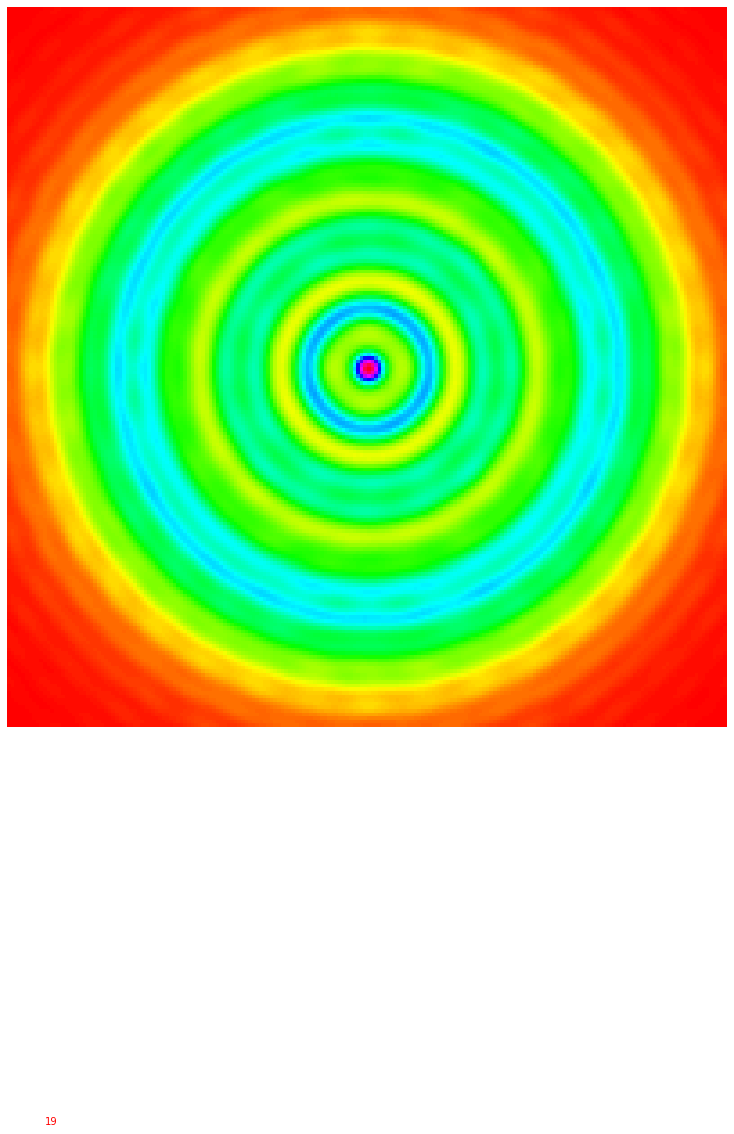

In [28]:
L = 4e-3
N = 200
M = np.full((N, N), True, dtype=bool)
animated_gif = AnimatedGif(size=(N, N))
animated_gif.add(M, label='0')
dx = L/N
x = np.linspace(-L/2,L/2-dx,N)
y = np.linspace(-L/2,L/2-dx,N)
X, Y = np.meshgrid(x, y)
images = []
z_step = np.linspace(0.015,0.03,20)
for i in range(len(z_step)):
#     M = abs(circular_aperature_ft_builtin_z(L,N,z_step[i]))**2
    M = abs(circular_aperature_sinc(L,N,z_step[i]))**2
    animated_gif.add(M, label=str(i))
 
# animated_gif.save('FT_z.gif')
animated_gif.save('Sinc_z_try.gif')

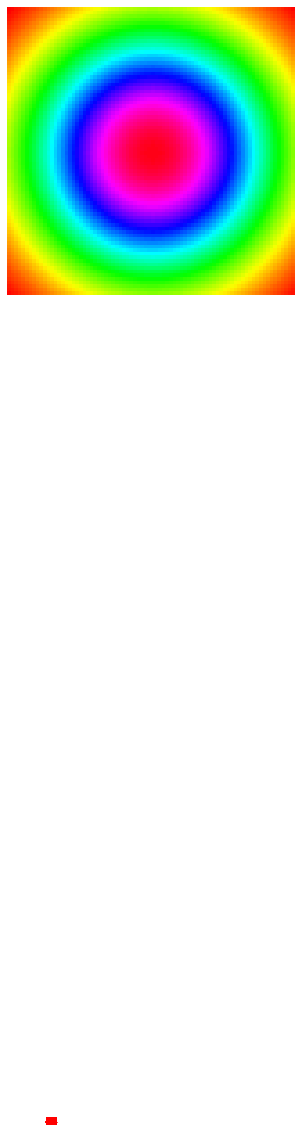

In [29]:
L = 1e-1
N = 80
M = np.full((N, N), True, dtype=bool)
animated_gif = AnimatedGif(size=(N, N))
animated_gif.add(M, label='0')

images = []
z_step = np.linspace(100,2000,100)
for i in range(len(z_step)):
#     M = abs(gaussian_ft_builtin(L,N,z_step[i]))**2
    M = abs(gaussian_sinc(L,N,z_step[i]))**2
    animated_gif.add(M, label=str(i))
 
# animated_gif.save('FT_z_gaussian.gif')
# animated_gif.save('Sinc_z_gaussian.gif')

In [30]:
from scipy.interpolate import interp2d

master_sinc = np.load('Master_sinc.npy')
N= 5000
L = 4e-3
dx = L/N
x = np.linspace(-L/2,L/2-dx,N)
y = np.linspace(-L/2,L/2-dx,N)

interp_sol = interp2d(x, y, abs(master_sinc),kind = 'quintic')

sinc_error_weight = []
sinc_error_rel = []
ft_error_weight = []
ft_error_rel = []


N_steps = np.arange(100,1000,100)

for i in range(len(N_steps)):
    N = N_steps[i]
    dx = L/N
    z = .015
    xnew = np.linspace(-L/2,L/2-dx,N)
    ynew = np.linspace(-L/2,L/2-dx,N)
    interp = interp_sol(xnew,ynew)
    sinc = circular_aperature_sinc(L,N,z)
    ft = circular_aperature_ft_builtin(L,N,z)
    sinc_error_weight.append(np.linalg.norm(abs(interp) - abs(sinc))/N**2)
    ft_error_weight.append(np.linalg.norm(abs(interp) - abs(ft))/N**2)
    
A1 = np.vstack([np.log10(N_steps), np.ones(len(np.log10(N_steps)))]).T
a_sinc,b_sinc = np.linalg.lstsq(A1,np.log10(sinc_error_weight),rcond = -1)[0]
a_fft,b_fft = np.linalg.lstsq(A1,np.log10(ft_error_weight),rcond = -1)[0]
np.round(a2,decimals = 2)
    
plt.plot(np.log10(N_steps),np.log10(sinc_error_weight),label = 'Sinc y = ' + str(np.round(a_sinc,decimals = 2))+'x + ' + str(np.round(b_sinc,decimals = 2)))
plt.plot(np.log10(N_steps),np.log10(ft_error_weight),label = 'FT y = ' + str(np.round(a_fft,decimals = 2))+'x + ' + str(np.round(b_fft,decimals = 2)))
plt.xlabel('N')
plt.ylabel('Weighted error - 1/N')
plt.title('Error vs. interpolation(Sinc N = 5000)')
plt.legend()
plt.show()
    

FileNotFoundError: [Errno 2] No such file or directory: 'Master_sinc.npy'

In [31]:
sinc_error_weight = np.load('sinc_error_weight.npy')
ft_error_weight = np.load('ft_error_weight.npy')
# np.save('sinc_error_weight',sinc_error_weight)
# np.save('ft_error_weight',ft_error_weight)
N_steps = np.arange(100,2100,100)
A1 = np.vstack([np.log10(N_steps), np.ones(len(np.log10(N_steps)))]).T
a_sinc,b_sinc = np.linalg.lstsq(A1,np.log10(sinc_error_weight),rcond = -1)[0]
a_fft,b_fft = np.linalg.lstsq(A1,np.log10(ft_error_weight),rcond = -1)[0]
# np.round(a2,decimals = 2)
    
plt.plot(np.log10(N_steps),a_sinc*np.log10(N_steps)+b_sinc,label = 'y = ' + str(np.round(a_sinc,decimals = 2))+'x + ' + str(np.round(b_sinc,decimals = 2)))
plt.plot(np.log10(N_steps),a_fft*np.log10(N_steps)+b_fft,label = 'y = ' + str(np.round(a_fft,decimals = 2))+'x + ' + str(np.round(b_fft,decimals = 2)))
plt.scatter(np.log10(N_steps),np.log10(sinc_error_weight),label = 'Sinc',c = 'gray')
plt.scatter(np.log10(N_steps),np.log10(ft_error_weight),label = 'FT',c = 'black')
plt.xlabel('N')
plt.ylabel('Weighted error - 1/N')
plt.title('L2 Error')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'sinc_error_weight.npy'